In [1]:
import matplotlib.pyplot as plt
from datetime import date
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import wrangle
import explore
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import RobustScaler, MinMaxScaler, QuantileTransformer,PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error


In [2]:
df = wrangle.wrangle_zillow()

There are 52441 different homes in this data set


In [3]:
la, oc, ven = wrangle.county_split(df)

In [4]:
def split(df):    
    train, test = train_test_split(df, random_state=123)
    train, validate = train_test_split(train,random_state=123)
    return(train,validate,test)

def model_split(train,validate,test):
    x_train = train.drop(columns='tax_value')
    y_train = train.tax_value

    x_validate = validate.drop(columns='tax_value')
    y_validate = validate.tax_value

    x_test = test.drop(columns='tax_value')
    y_test = test.tax_value
    
    return(x_train,y_train,x_validate,y_validate,x_test,y_test)

In [5]:
def models(df):
    #split the data
    train,validate,test = split(df)
    x_train, y_train,x_validate,y_validate,x_test,y_test = model_split(train,validate,test)
    
    #combine bed and bath
    x_train['bed_bath'] = x_train.bedrooms + x_train.bathrooms
    x_train=x_train.drop(columns=['bedrooms','bathrooms'])
    x_validate['bed_bath'] = x_validate.bedrooms + x_validate.bathrooms
    x_validate=x_validate.drop(columns=['bedrooms','bathrooms'])
    x_test['bed_bath'] = x_test.bedrooms + x_test.bathrooms
    x_test=x_test.drop(columns=['bedrooms','bathrooms'])
    
    # scale the data
    scaler = MinMaxScaler()
    scaler.fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_train_scaled = pd.DataFrame(x_train_scaled)
    x_train_scaled.columns = x_train.columns.tolist()
    
    x_validate_scaled = scaler.transform(x_validate)
    x_validate_scaled = pd.DataFrame(x_validate_scaled)
    x_validate_scaled.columns = x_train_scaled.columns.tolist()

    x_test_scaled = scaler.transform(x_test)
    x_test_scaled = pd.DataFrame(x_test_scaled)
    x_test_scaled.columns = x_train_scaled.columns.tolist()
    # create a model object for the RFE
    lm = LinearRegression()
    # select the most useful features
    rfe = RFE(lm, n_features_to_select=5)
    rfe.fit(x_train_scaled,y_train)
    feature_mask = rfe.support_
    rfe_feature = x_train_scaled.iloc[:,feature_mask].columns.tolist()
    print(f'The 5 most useful features for this county are {rfe_feature}',
         '\n---------------')
    
    # limit data frame to only the most useful features
    x_train_scaled= x_train_scaled[rfe_feature]
    x_validate_scaled= x_validate_scaled[rfe_feature]
    x_test_scaled= x_test_scaled[rfe_feature]
    
    # Change series into data frame
    y_train = pd.DataFrame(y_train)
    y_validate = pd.DataFrame(y_validate)
    y_test = pd.DataFrame(y_test)
    
    # compare baseline as mean vs baseline as median
    baseline_mean = round(y_train.tax_value.mean(),2)
    baseline_median = y_train.tax_value.median()

    y_train['baseline_mean'] = baseline_mean
    y_train['baseline_median'] = baseline_median

    y_validate['baseline_mean'] = baseline_mean
    y_validate['baseline_median'] = baseline_median
    
    
    #calculate errors for baseline
    rmse_train = mean_squared_error(y_train.tax_value, y_train.baseline_mean)**(1/2)
    rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.baseline_mean)**(1/2)

    print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2),
         "\n-----------------")

    rmse_train = mean_squared_error(y_train.tax_value, y_train.baseline_median)**(1/2)
    rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.baseline_median)**(1/2)

    print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2),
         "\n-----------------")
    
    
    # create the model object
    lm = LinearRegression(normalize=True)


    lm.fit(x_train_scaled, y_train.tax_value)

    # predict train
    y_train['pred_lm'] = lm.predict(x_train_scaled)

    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.tax_value, y_train.pred_lm)**(1/2)

    # predict validate
    y_validate['pred_lm'] = lm.predict(x_validate_scaled)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.pred_lm)**(1/2)

    print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
          f'\nmodel performed {(221854.16-rmse_train)/221854.16 :.2%} better than baseline',
         "\n-----------------")

    
    # create the model object
    lars = LassoLars(alpha=1.0)
    lars.fit(x_train_scaled, y_train.tax_value)

    # predict train
    y_train['pred_lars'] = lars.predict(x_train_scaled)

    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.tax_value, y_train.pred_lars)**(1/2)

    # predict validate
    y_validate['pred_lars'] = lars.predict(x_validate_scaled)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.pred_lars)**(1/2)

    print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
          f'\nmodel performed {(221854.16-rmse_train)/221854.16 :.2%} better than baseline',
         "\n-----------------")

    
    
    pf = PolynomialFeatures(degree=4)

    # fit and transform X_train_scaled
    x_train_degree2 = pf.fit_transform(x_train_scaled)

    # transform X_validate_scaled & X_test_scaled
    x_validate_degree2 = pf.transform(x_validate_scaled)
    x_test_degree2 = pf.transform(x_test_scaled)

    
    # create the model object
    lm2 = LinearRegression(normalize=True )

    lm2.fit(x_train_degree2, y_train.tax_value)

    # predict train
    y_train['pred_lm2'] = lm2.predict(x_train_degree2)

    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.tax_value, y_train.pred_lm2)**(1/2)

    # predict validate

    y_validate['pred_lm2'] = lm2.predict(x_validate_degree2)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.pred_lm2)**(1/2)

    print("RMSE for Polynomial Model, degrees=4\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
          f'\nmodel performed {(221854.16-rmse_train)/221854.16 :.2%} better than baseline',
         "\n-----------------")
    
    # create the model object
    glm = TweedieRegressor(power=1, alpha=0)

    glm.fit(x_train_scaled, y_train.tax_value)

    # predict train
    y_train['pred_glm'] = glm.predict(x_train_scaled)

    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.tax_value, y_train.pred_glm)**(1/2)

    # predict validate
    y_validate['pred_glm'] = glm.predict(x_validate_scaled)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.pred_glm)**(1/2)

    print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining: ", rmse_train, 
      "\nValidation: ", rmse_validate,
          f'\nmodel performed {(221854.16-rmse_train)/221854.16 :.2%} better than baseline',
         )
    
    
    plt.figure(figsize=(16,8))
    plt.plot(y_validate.tax_value, y_validate.baseline_mean, alpha=1, color="red", label='_nolegend_')
    
    plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=1, color="orange", label='_nolegend_')
    plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5))

    plt.scatter(y_validate.tax_value, y_validate.pred_lm, 
            alpha=.5, color="red", s=10, label="Model: LinearRegression")
    plt.scatter(y_validate.tax_value, y_validate.pred_lars, 
            alpha=.5, color="magenta", s=10, label="Model: LinearRegression")
    plt.scatter(y_validate.tax_value, y_validate.pred_glm, 
            alpha=.5, color="blue", s=10, label="Model: TweedieRegressor")
    plt.scatter(y_validate.tax_value, y_validate.pred_lm2, 
            alpha=.5, color="green", s=10, label="Model 4th degree Polynomial")
    plt.legend()
    plt.xlabel("Actual Tax Value")
    plt.ylabel("Predicted Tax Value")
    plt.title("Where are predictions closest to the actual?")
    plt.show()


The 5 most useful features for this county are ['quality', 'sq_feet', 'pool', 'age', 'bed_bath'] 
---------------
RMSE using Mean
Train/In-Sample:  291781.43 
Validate/Out-of-Sample:  291280.41 
-----------------
RMSE using Median
Train/In-Sample:  299993.71 
Validate/Out-of-Sample:  299729.78 
-----------------
RMSE for OLS using LinearRegression
Training/In-Sample:  251886.56907538307 
Validation/Out-of-Sample:  252509.98995267268 
model performed -13.54% better than baseline 
-----------------
RMSE for Lasso + Lars
Training/In-Sample:  251887.06231604202 
Validation/Out-of-Sample:  252515.65527544433 
model performed -13.54% better than baseline 
-----------------
RMSE for Polynomial Model, degrees=4
Training/In-Sample:  245782.3876428724 
Validation/Out-of-Sample:  247693.3116452136 
model performed -10.79% better than baseline 
-----------------
RMSE for GLM using Tweedie, power=1 & alpha=0
Training:  256648.15243025366 
Validation:  258794.19652422846 
model performed -15.68% bet

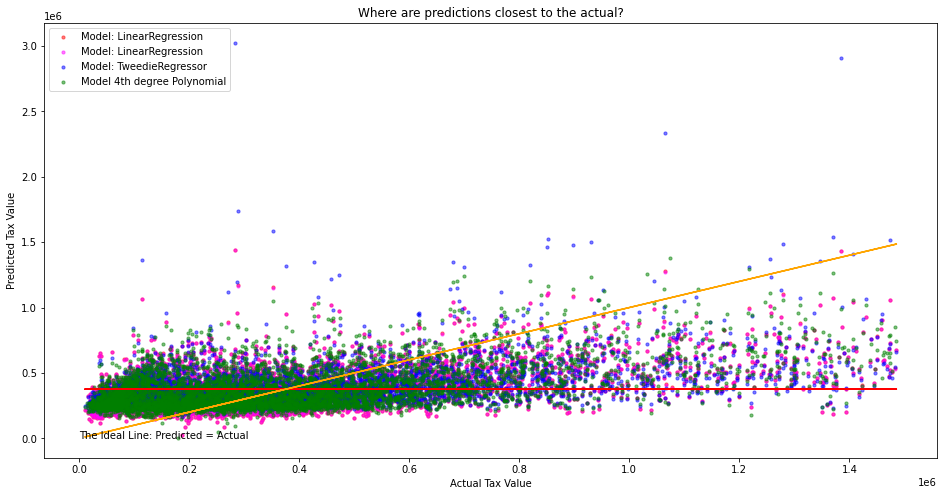

In [6]:
models(la)

The 5 most useful features for this county are ['quality', 'sq_feet', 'pool', 'age', 'bed_bath'] 
---------------
RMSE using Mean
Train/In-Sample:  313490.39 
Validate/Out-of-Sample:  300874.37 
-----------------
RMSE using Median
Train/In-Sample:  316645.13 
Validate/Out-of-Sample:  302687.12 
-----------------
RMSE for OLS using LinearRegression
Training/In-Sample:  230295.92626423322 
Validation/Out-of-Sample:  230398.8359508579 
model performed -3.81% better than baseline 
-----------------
RMSE for Lasso + Lars
Training/In-Sample:  230296.10863746272 
Validation/Out-of-Sample:  230397.48458223353 
model performed -3.81% better than baseline 
-----------------
RMSE for Polynomial Model, degrees=4
Training/In-Sample:  220479.8197074743 
Validation/Out-of-Sample:  227400.004672966 
model performed 0.62% better than baseline 
-----------------
RMSE for GLM using Tweedie, power=1 & alpha=0
Training:  230144.9219077135 
Validation:  229167.65932545476 
model performed -3.74% better than

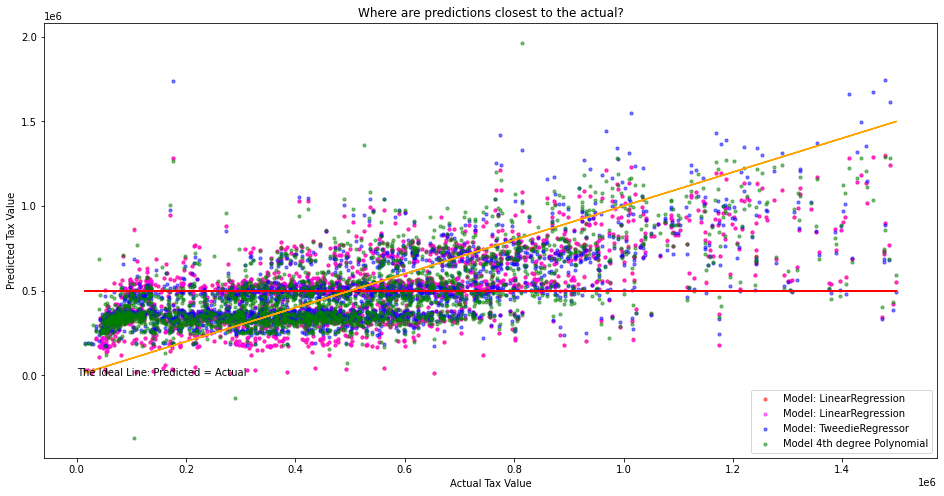

In [7]:
models(oc)

The 5 most useful features for this county are ['quality', 'sq_feet', 'pool', 'age', 'bed_bath'] 
---------------
RMSE using Mean
Train/In-Sample:  282318.97 
Validate/Out-of-Sample:  266666.09 
-----------------
RMSE using Median
Train/In-Sample:  284774.79 
Validate/Out-of-Sample:  268159.15 
-----------------
RMSE for OLS using LinearRegression
Training/In-Sample:  188760.7908523455 
Validation/Out-of-Sample:  182553.89593095068 
model performed 14.92% better than baseline 
-----------------
RMSE for Lasso + Lars
Training/In-Sample:  188760.86560802214 
Validation/Out-of-Sample:  182554.89328696634 
model performed 14.92% better than baseline 
-----------------
RMSE for Polynomial Model, degrees=4
Training/In-Sample:  180580.3664183988 
Validation/Out-of-Sample:  186210.39715618078 
model performed 18.60% better than baseline 
-----------------
RMSE for GLM using Tweedie, power=1 & alpha=0
Training:  194836.78996138825 
Validation:  193924.8678998627 
model performed 12.18% better t

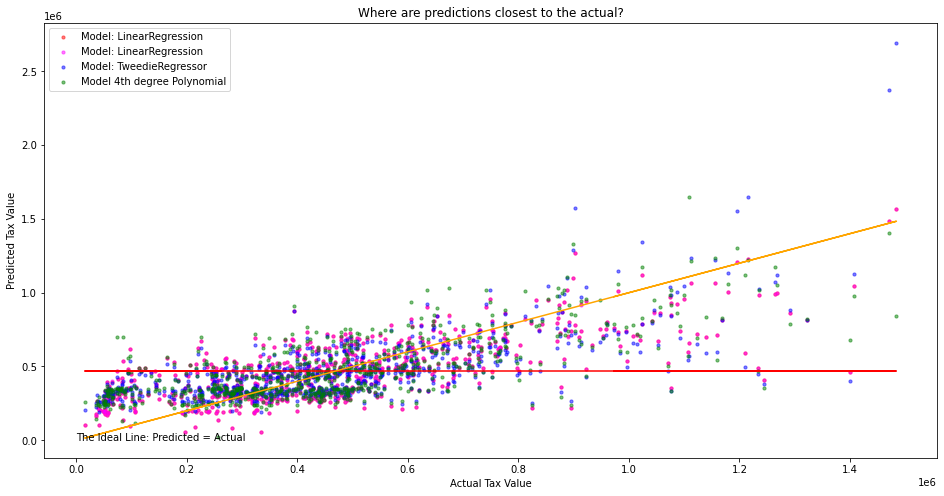

In [8]:
models(ven)